## Unit 2 Sprint 2
### kaggle challenge notebook

## EDA

In [1]:
# for cheking the installed modules
import sys
# part of the trio
import numpy as np
import pandas as pd
# for CV
from sklearn.model_selection import train_test_split

# pandas profiling broken on local env
# import pandas_profiling
# from pandas_profiling import ProfileReport


In [4]:
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/waterpumps/'

In [5]:
train = pd.merge(pd.read_csv(DATA_PATH+'train_features.csv'), 
                 pd.read_csv(DATA_PATH+'train_labels.csv'))
test = pd.read_csv(DATA_PATH+'test_features.csv') 
sample_submission = pd.read_csv(DATA_PATH+'sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

## Data Cleaning

In [6]:
def Data_cleaning(X):
 
  # make a copy of the data
  X = X.copy()
  # get rid of outliers  
  X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
  # When columns have zeros and shouldn't, they are like null values.
  # So we will replace the zeros with nulls, and impute missing values later.
    
  cols_with_zeros = ['longitude', 'latitude','population','construction_year']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)

  # add try catch to ignore rerun of cell 
  try:        
    # drop redundant column
    X = X.drop(columns='quantity_group')
    X=X.drop('recorded_by',axis=1)

    # change 'unkown' to nan
    X['source_class']=X['source_class'].replace("unknown",np.NaN)

    # not a dup but not usefull %0 variance
  except:
    print("Cell is rerun")

  # define a list of columns to iterate through
  # originially this was an argument for the function but i moved it inside
  column=['funder','installer','region','scheme_name']
  # if a list is passed then make changes for all elements in that list of column names
  if isinstance(column,list):
    for ele in column:
      top10=X[ele].value_counts()[:10].index
      X.loc[~X[ele].isin(top10), ele] = 'other'
  # if one name is passed then just change that one column
  else:
    top10=X[column].value_counts()[:10].index
    X.loc[~X[column].isin(top10), column] = 'other'
  return X


In [7]:
train=Data_cleaning(train)
test=Data_cleaning(test)

In [13]:
target = 'status_group'
ignore=['date_recorded','id',target]
cat_features=[x for x in train.describe(exclude='number').columns.to_list() if x not in ignore]
num_features=[x for x in train.describe(include='number').columns.to_list() if x not in ignore]

# Get a series with the cardinality of the nonnumeric features
cardinality = train[cat_features].select_dtypes(exclude='number').nunique()
# Get a list of all categorical features with cardinality <= 50
cat_features = cardinality[cardinality <= 50].index.tolist()

# set features and target
target = 'status_group'
features = cat_features + num_features

train,val=train_test_split(train)

# make feature sets and labels
X_train=train[features]
X_val=val[features]

y_train=train[target]
y_val=val[target]

# make test feature set
X_test=test[features]

print(f"train shape:{train.shape}\n\
validation shape:{val.shape}\n\
testing shape:{test.shape}")

train shape:(14095, 39)
validation shape:(4699, 39)
testing shape:(14358, 38)


## set up a pipeline to get a baseline model

# A Mess **todo**:clean

In [70]:
# import preprocessing stuff
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder,CatBoostEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# imputer
from sklearn.impute import SimpleImputer

# import a bunch of models that i want to test
from sklearn.linear_model import LogisticRegression,SGDClassifier 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

# import test metrics
from sklearn.metrics import accuracy_score,confusion_matrix


pipeline = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='most_frequent'),
    StandardScaler(),  
    XGBClassifier(objective='multi:softmax',booster='gbtree',nrounds='min.error.idx',num_class=3,eval_metric='merror'))
print([str(x) for x in pipeline.named_steps])


['onehotencoder', 'simpleimputer', 'standardscaler', 'xgbclassifier']


In [71]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    #'xgbclassifier__objective': 'multi:softmax', 
    #'xgbclassifier__booster':'gbtree', 
    #'xgbclassifier__nrounds':'min.error.idx',
    #'xgbclassifier__num_class': 3,
    'xgbclassifier__maximize':[False,True],
    #'xgbclassifier__eval_metric':'merror',
    'xgbclassifier__eta':[0.1,0.2,0.5,0.8,1],
    'xgbclassifier__max_depth': [10,15,20,25],
    'xgbclassifier__colsample_bytree':[0.2,0.4,0.6]
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=20, 
    cv=5, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 17.9min remaining:   44.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 18.2min finished


In [72]:
print(search.best_score_)
print(search.best_params_)
y_pred=search.predict(X_train)
print(f"RandomForest_pipe:\n\tTRAIN ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_train)}")
y_pred=search.predict(X_val)
print(f"\tVALIDATION ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_val)}")

0.7860234125576445
{'xgbclassifier__maximize': False, 'xgbclassifier__max_depth': 15, 'xgbclassifier__eta': 0.8, 'xgbclassifier__colsample_bytree': 0.4}
RandomForest_pipe:
	TRAIN ACCURACY:0.9753813409010287
	VALIDATION ACCURACY:0.7882528197488827


In [19]:
#model=RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
#                       criterion='entropy', max_depth=None,
#                       max_features=0.4, max_leaf_nodes=None,
#                       max_samples=None, min_impurity_decrease=0.0,
#                       min_impurity_split=None, min_samples_leaf=6,
#                       min_samples_split=2, min_weight_fraction_leaf=0.0,
#                       n_estimators=1000, n_jobs=-1, oob_score=False,
#                       random_state=42, verbose=False, warm_start=False)

In [20]:
#model_pipe=make_pipeline(OneHotEncoder(use_cat_names=True),
#                      SimpleImputer(strategy='most_frequent'),
#                      StandardScaler(),
#                      model)
#

In [21]:
# hyperopt suggested model
#RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
#                       criterion='entropy', max_depth=None,
#                       max_features=0.43626285313652846, max_leaf_nodes=None,
#                       max_samples=None, min_impurity_decrease=0.0,
#                       min_impurity_split=None, min_samples_leaf=1,
#                       min_samples_split=2, min_weight_fraction_leaf=0.0,
#                       n_estimators=11, n_jobs=1, oob_score=False,
#                       random_state=0, verbose=False, warm_start=False)
model_pipe.fit(X_train,y_train)
y_pred=model_pipe.predict(X_train)
print(f"RandomForest_pipe:\n\tTRAIN ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_train)}")
y_pred=model_pipe.predict(X_val)
print(f"\tVALIDATION ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_val)}")

RandomForest_pipe:
	TRAIN ACCURACY:0.9052146151117417
	VALIDATION ACCURACY:0.7788891253458182


TypeError: confusion_matrix() missing 2 required positional arguments: 'y_true' and 'y_pred'

In [27]:
val[target].value_counts()

functional                 2494
non functional             1881
functional needs repair     324
Name: status_group, dtype: int64

[[2233   54  207]
 [ 188   87   49]
 [ 508   33 1340]]


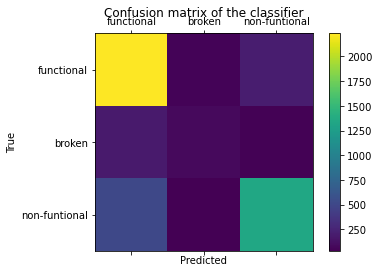

In [25]:
import matplotlib.pyplot as plt
labels = ['functional', 'broken','non-funtional']
cm = confusion_matrix(y_val, y_pred)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## results from diffrent models, baseline was a logistic regression

In [21]:
y_pred=pipe.predict(X_train)
print(f"BASELINE:\n\tTRAIN ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_train)}")
y_pred=pipe.predict(X_val)
print(f"\tVALIDATION ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_val)}")

BASELINE:
	TRAIN ACCURACY:0.7414622414622415
	VALIDATION ACCURACY:0.7425845759179093


In [24]:
y_pred=SGDClassifier_pipe.predict(X_train)
print(f"SGDClassifier:\n\tTRAIN ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_train)}")
y_pred=SGDClassifier_pipe.predict(X_val)
print(f"\tVALIDATION ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_val)}")

SGDClassifier:
	TRAIN ACCURACY:0.721878650450079
	VALIDATION ACCURACY:0.7237453904120571


In [26]:
y_pred=SVC_pipe.predict(X_train)
print(f"SVC_pipe:\n\tTRAIN ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_train)}")
y_pred=SVC_pipe.predict(X_val)
print(f"\tVALIDATION ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_val)}")

SVC_pipe:
	TRAIN ACCURACY:0.7914175771318629
	VALIDATION ACCURACY:0.7725669392336059


In [30]:
y_pred=DecisionTreeClassifier_pipe.predict(X_train)
print(f"DecisionTreeClassifier_pipe:\n\tTRAIN ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_train)}")
y_pred=DecisionTreeClassifier_pipe.predict(X_val)
print(f"\tVALIDATION ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_val)}")

DecisionTreeClassifier_pipe:
	TRAIN ACCURACY:0.9965299251013536
	VALIDATION ACCURACY:0.7456309122975789


In [32]:
# min_samples_leaf=20
y_pred=DecisionTreeClassifier_pipe.predict(X_train)
print(f"DecisionTreeClassifier_pipe:\n\tTRAIN ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_train)}")
y_pred=DecisionTreeClassifier_pipe.predict(X_val)
print(f"\tVALIDATION ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_val)}")

DecisionTreeClassifier_pipe:
	TRAIN ACCURACY:0.7983920841063699
	VALIDATION ACCURACY:0.7524450857784191


In [38]:
# min_samples_split=10
# min_samples_leaf=10
y_pred=DecisionTreeClassifier_pipe.predict(X_train)
print(f"DecisionTreeClassifier_pipe:\n\tTRAIN ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_train)}")
y_pred=DecisionTreeClassifier_pipe.predict(X_val)
print(f"\tVALIDATION ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_val)}")

DecisionTreeClassifier_pipe:
	TRAIN ACCURACY:0.8297258297258298
	VALIDATION ACCURACY:0.7594997594997595


In [40]:
# min_samples_split=10
# min_samples_leaf=10
y_pred=DecisionTreeClassifier_pipe.predict(X_train)
print(f"DecisionTreeClassifier_pipe:\n\tTRAIN ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_train)}")
y_pred=DecisionTreeClassifier_pipe.predict(X_val)
print(f"\tVALIDATION ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_val)}")

DecisionTreeClassifier_pipe:
	TRAIN ACCURACY:0.829863258434687
	VALIDATION ACCURACY:0.7625460958794292


## current model

In [20]:

#              XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx', 
#                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .1,
#                      max_depth = 14, colsample_bytree = .4)

y_pred=XGB_pipe.predict(X_train)
print(f"XGB_pipe:\n\tTRAIN ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_train)}")
y_pred=XGB_pipe.predict(X_val)
print(f"\tVALIDATION ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_val)}")

XGB_pipe:
	TRAIN ACCURACY:0.9383164983164983
	VALIDATION ACCURACY:0.8111784511784512


## pickleing the fitted model for faster loading

In [62]:
import pickle as salt
from time import time

In [63]:
try:
  file_f=open('searchcv_{}.pickle'.format(time()),'wb')  
  salt.dump(search,file_f)
except Exception as e:
  print(e)
finally:
  file_f.close()


### make a kaggle submission csv for ds-13-waterpumps

In [58]:
y_pred=model_pipe.predict(X_test)

In [60]:
export=pd.DataFrame(index=test['id'],data=y_pred,columns=[target])
export.reset_index(inplace=True)

In [61]:
export.to_csv("submission_{}.csv".format(time()),index=False)